**Are California Police biased?**

Within the past few years, racial prejudices of police officers has been a hot topic. Partly to address this debate, provide transperancy, and provide some notion of formal analysis, Stanford has released the Open Policing Project which aggregates data from various states in the USA, consisting of approximately 60 million traffic stops. Since I am a California native, and California is well known for being a highly liberal state, I decided to analyze the California traffic stop data. This notebook in R consists of my findings and analysis. My blog probabilitymeasure.blog will contain commentary and interpretation of this notebook.

In [1]:
#load packages
library(readr)
library(ggplot2)
library(zoo)
library(data.table)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [2]:
#load data
CA_cleaned <- read_csv("CA_cleaned.csv", 
    col_types = cols(county_fips = col_skip(), 
        driver_age = col_skip(), driver_race_raw = col_skip(), 
        ethnicity = col_skip(), fine_grained_location = col_skip(), 
        id = col_skip(), location_raw = col_skip(), 
        police_department = col_skip(), search_type_raw = col_skip(), 
        state = col_skip(), stop_time = col_skip(), 
        violation_raw = col_skip()))

Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, locale_, :
"length of NULL cannot be changed"Warning message in read_tokens_(data, tokenizer, col_specs, col_names, l

In [3]:
dim(CA_cleaned)

[1] 7777857      11

As we can see the data is hyooge.

We have some missing data pertaining to the outcomes and the driver race, our variables of interest. The data is too large to try and impute it in a rigorous way (though we probably could), so for now we just remove it. Assuming that the missing data comes from the same distribution as our data set, the number of missing cases is inconsequential.

Later, we will take a closer look at the cases with missing contraband, but for now we set it aside.

In [4]:
colMeans(is.na(CA_cleaned))

stop_date      county_name    driver_gender   driver_age_raw 
    0.000000e+00     7.506926e-02     0.000000e+00     0.000000e+00 
     driver_race        violation search_conducted      search_type 
    1.285701e-07     0.000000e+00     0.000000e+00     9.645387e-01 
contraband_found     stop_outcome      is_arrested 
    3.401451e-02     3.342823e-06     3.342823e-06

In [5]:
columns <- c('driver_race', 'stop_outcome', 'is_arrested')
miss_cntrbnd <- CA_cleaned[is.na(CA_cleaned$contraband_found),]
data <- CA_cleaned[complete.cases(CA_cleaned[, columns]),]
#data$contraband_missing <- (CA_cleaned$contraband_found == 'NA')
rm(CA_cleaned, columns)
#sum(data$contraband_missing)

In [6]:
colMeans(is.na(data))

stop_date      county_name    driver_gender   driver_age_raw 
      0.00000000       0.07506914       0.00000000       0.00000000 
     driver_race        violation search_conducted      search_type 
      0.00000000       0.00000000       0.00000000       0.96453870 
contraband_found     stop_outcome      is_arrested 
      0.03401450       0.00000000       0.00000000

In [7]:
dim(data)
dim(miss_cntrbnd)

[1] 7777830      11

[1] 264560     11

We don't lose too much.
The next block just recodes the variables to be slightly more useful. Take note of the `driver_age_raw` category. We won't be able to fit a model to the entire data without crashing, so we will look at subsets of the data. In particular, we will look at `driver_age_raw` at 2 and 3, which is the 15-25 and 25-32 age bracket, though almost all groups will get a look. We will also recode the violation and the dates. The missing values in `search_type` correspond to when a search was *not* conducted, so we can just add a string indicating that later. We also fill in the missing county name with a string instead of deleting those cases, as the missingness could be informative.

In [8]:
data$driver_gender <- (data$driver_gender == 'M') * 1
data$search_conducted <- data$search_conducted * 1
data$is_arrested <- data$is_arrested * 1
data$contraband_found <- data$contraband_found * 1
data$stop_date <- as.Date(data$stop_date, '%Y-%m-%d')
data$stop_date <- as.yearmon(data$stop_date)
data$search_type[data$search_conducted == 1 & is.na(data$search_type)] <- 'None'

#looks like a logging error, we remove it
data <- data[!(data$driver_age_raw == '7'), ]

#relabel the rest
data$driver_age_raw[data$driver_age_raw == '0-14'] <- 1
data$driver_age_raw[data$driver_age_raw == '15-25'] <- 2
data$driver_age_raw[data$driver_age_raw == '25-32'] <- 3
data$driver_age_raw[data$driver_age_raw == '33-39'] <- 4
data$driver_age_raw[data$driver_age_raw == '40-48'] <- 5
data$driver_age_raw[data$driver_age_raw == '49+'] <- 6
data$driver_age_raw <- as.numeric(data$driver_age_raw)


data$violation[data$violation == 'DUI'] <- 0
data$violation[data$violation == 'Equipment'] <- 1
data$violation[data$violation == 'Moving violation'] <- 2
data$violation[data$violation == 'Other'] <- 3
data$violation <- as.numeric(data$violation)

data$county_name[is.na(data$county_name)] <- 'Missing'
data$count <- 1

#data$year <- year(data$stop_date)

In [9]:
head(data)

stop_date,county_name,driver_gender,driver_age_raw,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,count
Jul 2009,Stanislaus County,1,4,Other,3,0,NA,0,Motorist/Public Service,0,1
Jul 2009,Stanislaus County,0,6,Hispanic,2,0,NA,0,CHP 215,0,1
Jul 2009,Stanislaus County,0,4,Hispanic,2,1,Inventory,NA,CHP 215,0,1
Jul 2009,Stanislaus County,0,3,White,2,0,NA,0,CHP 215,0,1
Jul 2009,Stanislaus County,1,5,Hispanic,2,1,Inventory,NA,CHP 215,0,1
Jul 2009,Stanislaus County,1,2,Hispanic,2,0,NA,0,CHP 215,0,1


**Description of the data**
The data we will work with contains the variables seen in the header above. Most of it is fairly straightforward. `stop_date` and `county_name` give the year and month of the stop. Presently, there is not strong reason to believe that days of the week or month will have a significant effect on stop outcomes (would you believe that Cops give more tickets on a Monday? Maybe, but do you believe it would cause statistically significant differences in practically census-level data?) and so we take the courser date-time to just be the month and year. This also eases plotting down below. Later we will further collapse that into year for the regression models unless a convincing reason is found/given to not do this. The time frame of the data ranges from 2009 to 2016. There are 55 counties in all, if the `"Missing"` county is included.

`search_conducted` is a binary indicator denoting whether a search was done, where 1 means "yes". We also have `search_type` which indicates how/why the search was conducted. Of particular note are the categories `"Probable Cause"` and `"Incident to Arrest"`.  

`contraband_found` is an indicator for whether some paraphilinilia was found. Unfortunately, we do not have data on what the contraband was, but it could range from (say) drugs to weapons.

`stop_outcome` is a categorical variable indicating what the end result of the traffic stop was. Of particular note is `"Verbal Warning"`, which we will analyze later. 

Finally, `is_arrested` is clear. It's an indicator whether that person was arrested or not. What is not clear, is why the arrest occurred. It is not true that the arrest always comes after a search, as some individuals were arrested, THEN searched as noted by `"Incident to Arrest"'. 

**Time Series Plotting**

We plot some time series trends in the data, grouped by race, after some aggregation to make the data actually readable. (If you try to plot this without aggregation, having thousands of stops on the same day for years makes the data too noisy to interpret).


In [11]:
setDT(data)
time_data <- data[, lapply(.SD, sum, na.rm=TRUE),
           by=list(stop_date, driver_race),
                   .SDcols=c('search_conducted',
                             'is_arrested',
                             'contraband_found',
                             #'contraband_missing',
                             'count')]
head(time_data)

stop_date,driver_race,search_conducted,is_arrested,contraband_found,count
Jul 2009,Other,593,548,20,28827
Jul 2009,Hispanic,8041,5297,126,140651
Jul 2009,White,5075,4516,187,202023
Jul 2009,Black,1509,1105,63,34718
Jul 2009,Asian,487,503,13,28015
Aug 2009,White,5288,4810,202,203804


Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


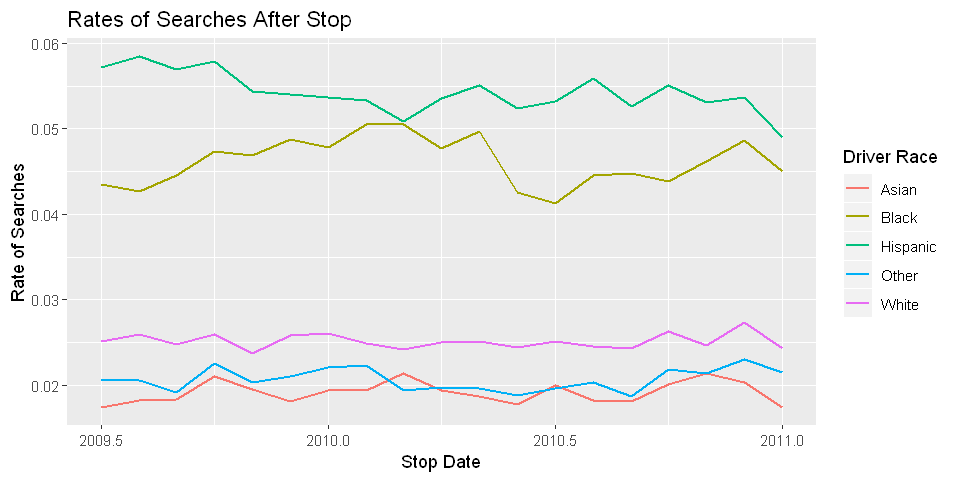

In [12]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data, aes(x = stop_date, y = search_conducted / count, colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('Rates of Searches After Stop') +
       xlab('Stop Date') +
       ylab('Rate of Searches') +
       labs(colour = 'Driver Race')

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


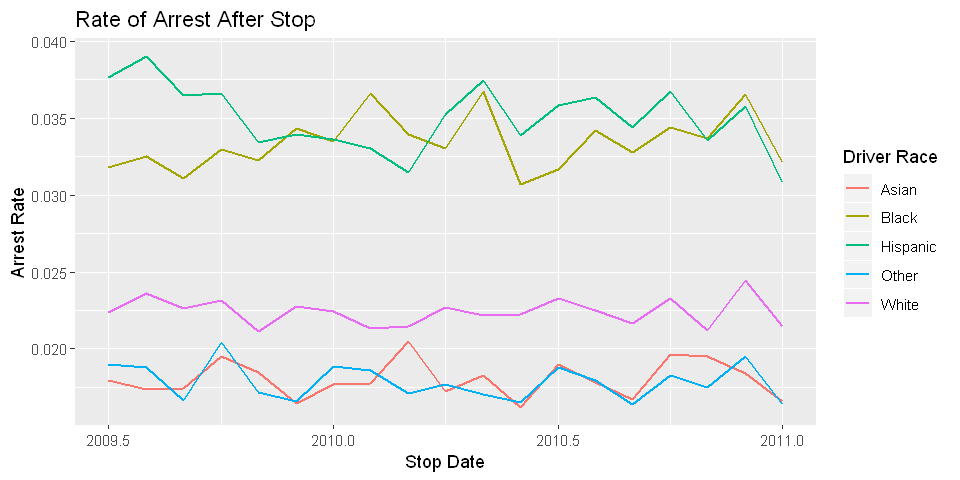

In [13]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data, aes(x = stop_date, y = is_arrested / count, colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('Rate of Arrest After Stop') +
       xlab('Stop Date') +
       ylab('Arrest Rate') +
       labs(colour = 'Driver Race')

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


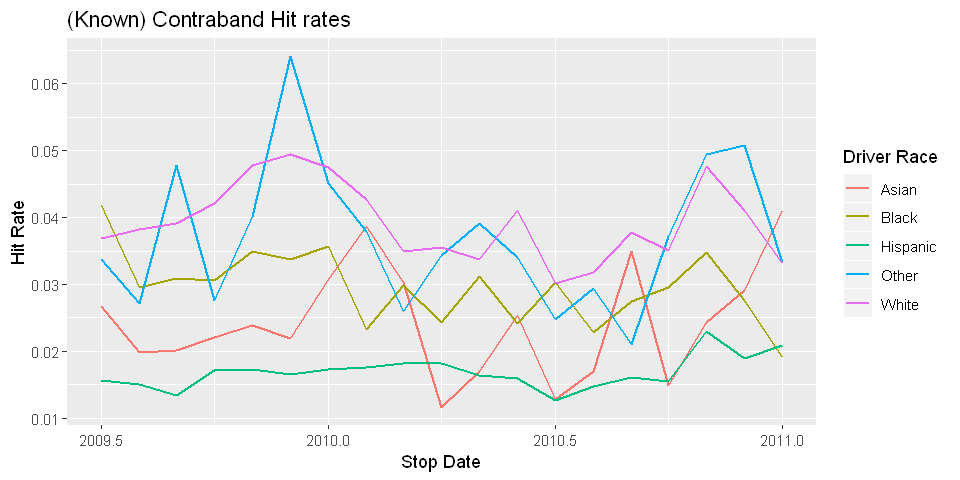

In [29]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data,
       aes(x = stop_date,
           y = contraband_found / (search_conducted),
           colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('(Known) Contraband Hit rates') +
       xlab('Stop Date') +
       ylab('Hit Rate') +
       labs(colour = 'Driver Race')

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


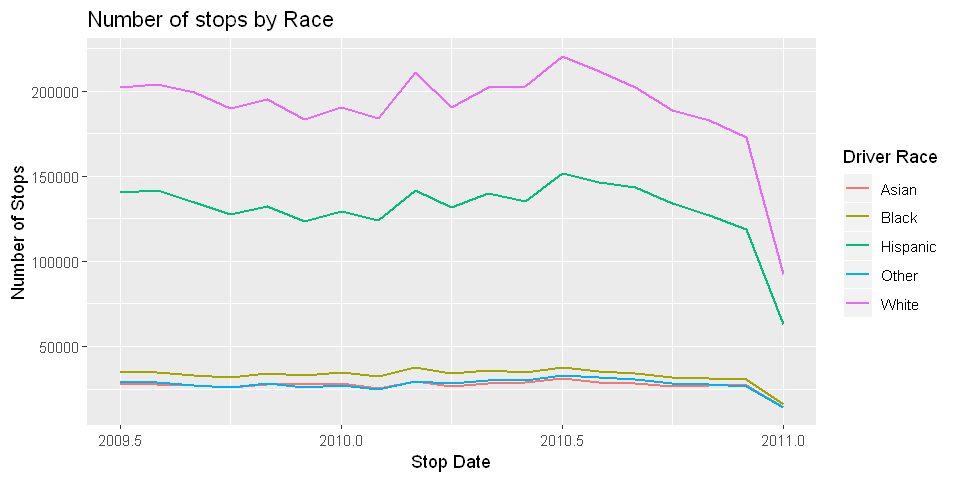

In [15]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data, aes(x = stop_date, y = count, colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('Number of stops by Race') +
       xlab('Stop Date') +
       ylab('Number of Stops') +
       labs(colour = 'Driver Race')

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


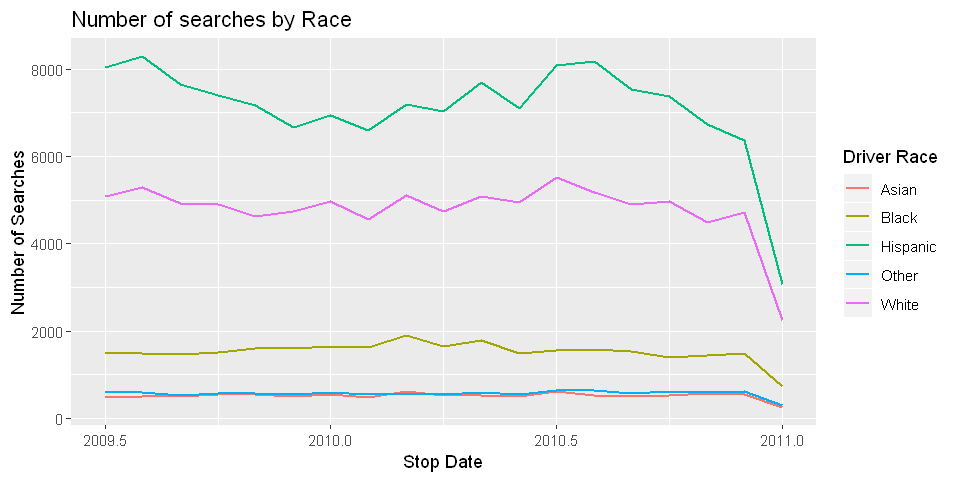

In [16]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data, aes(x = stop_date, y = search_conducted, colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('Number of searches by Race') +
       xlab('Stop Date') +
       ylab('Number of Searches') +
       labs(colour = 'Driver Race')

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


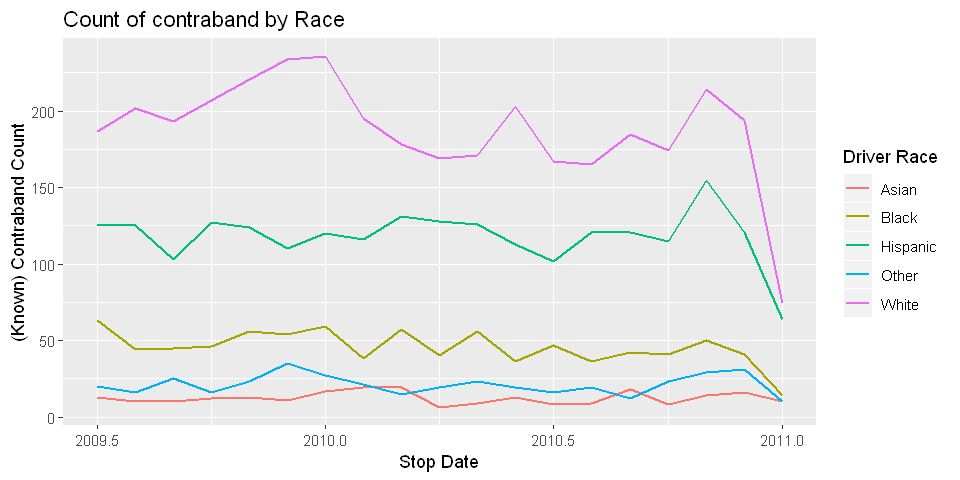

In [17]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = time_data, aes(x = stop_date, y = contraband_found, colour = driver_race)) + 
       geom_line(size = 0.60) +
       ggtitle('Count of contraband by Race') +
       xlab('Stop Date') +
       ylab('(Known) Contraband Count') +
       labs(colour = 'Driver Race')

In [18]:
sort( sapply(ls(),function(x){object.size(get(x))})) 

time_data miss_cntrbnd         data 
        7288     20114768    746680016

**Parameter estimates and simulations**

In [19]:
#proportion of males in the data
mean(data$driver_gender)

[1] 0.6973691

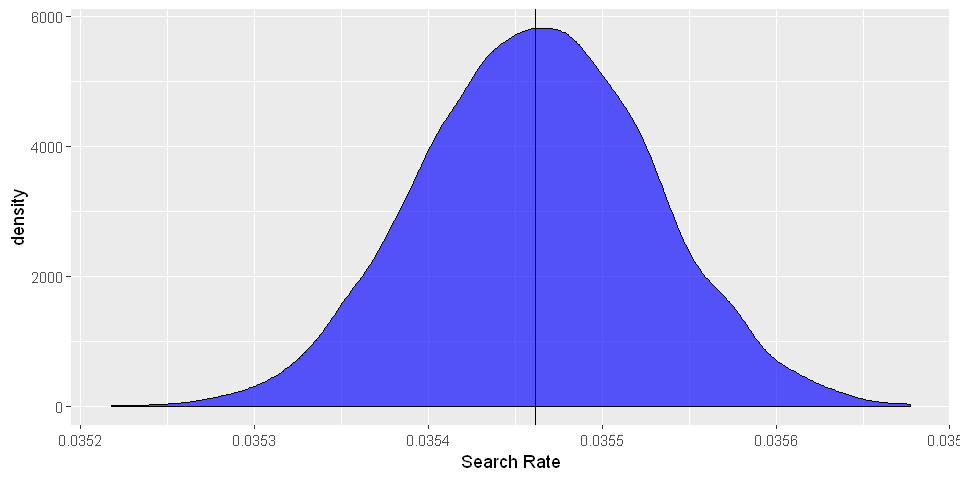

In [20]:
n_stops <- dim(data)[1]
n_search <- sum(data$search_conducted)
n_hits <- sum(data$contraband_found, na.rm = TRUE)
srch_rate <- n_search / n_stops
hit_rate <- n_hits / n_search
#plot the posterior distribution
#prior is beta(1/2, 1/2)
srch_samples <- rbeta(n = 5000, shape1 = n_search + 1/2, shape2 = n_stops - n_search + 1/2)
hit_samples <- rbeta(n = 5000, shape1 = n_hits + 1/2, shape2 = n_search - n_hits + 1/2)

ggplot() + 
    geom_density(aes(x = srch_samples), 
                   alpha = 0.65, 
                   fill = 'blue') +
    xlab('Search Rate') +
    geom_vline(xintercept = srch_rate) +
    geom_text(x = srch_rate, label = srch_rate)

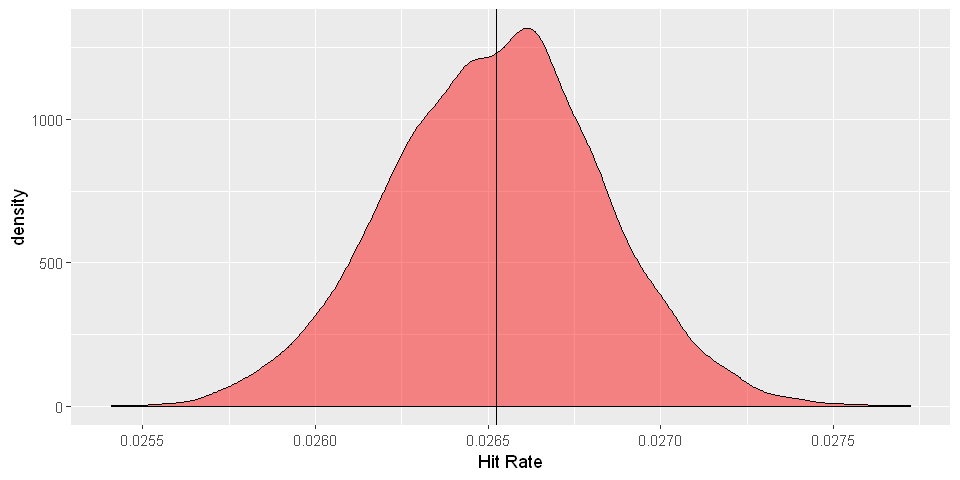

In [21]:
ggplot() + 
    geom_density(aes(x = hit_samples), 
                   alpha = 0.45,
                   fill = 'red') +
    xlab('Hit Rate') +
    geom_vline(xintercept = hit_rate) +
    geom_text(x = hit_rate, label =  hit_rate)

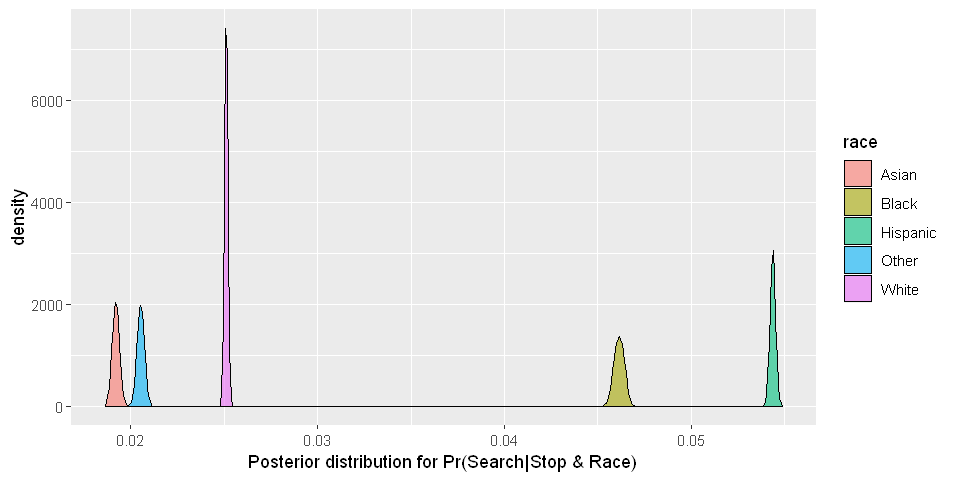

In [22]:
wht_n_stop <- dim(data[data$driver_race == 'White', ])[1]
wht_n_search <- sum(data[data$driver_race == 'White', ]$search_conducted)
wht_srch_rate <- wht_n_search / wht_n_stop

his_n_stop <- dim(data[data$driver_race == 'Hispanic', ])[1]
his_n_search <- sum(data[data$driver_race == 'Hispanic', ]$search_conducted)
his_srch_rate <- his_n_search / his_n_stop

blk_n_stop <- dim(data[data$driver_race == 'Black', ])[1]
blk_n_search <- sum(data[data$driver_race == 'Black', ]$search_conducted)
blk_srch_rate <- blk_n_search / blk_n_stop

asn_n_stop <- dim(data[data$driver_race == 'Asian', ])[1]
asn_n_search <- sum(data[data$driver_race == 'Asian', ]$search_conducted)
asn_srch_rate <- asn_n_search / asn_n_stop

otr_n_stop <- dim(data[data$driver_race == 'Other'])[1]
otr_n_search <- sum(data[data$driver_race == 'Other', ]$search_conducted)
otr_srch_rate <- otr_n_search / otr_n_stop

## MAKE AND PLOT PRIOR DISTRIBUTION OF SEARCH RATES FOR EACH RACE
## REPEAT THE SAME PROCESS IN ANOTHER BLOCK FOR THE HIT RATES

white_est <- data.frame(length = rbeta(n = 2000, 
                                       shape1 = wht_n_search + 1/2, 
                                       shape2 = wht_n_stop - wht_n_search + 1/2))
black_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = blk_n_search + 1/2,
                                          shape2 = blk_n_stop - blk_n_search + 1/2))

hispanic_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = his_n_search + 1/2,
                                          shape2 = his_n_stop - his_n_search + 1/2))

asian_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = asn_n_search + 1/2,
                                          shape2 = asn_n_stop - asn_n_search + 1/2))

other_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = otr_n_search + 1/2,
                                          shape2 = otr_n_stop - otr_n_search + 1/2))

white_est$race <- 'White'
black_est$race <- 'Black'
asian_est$race <- 'Asian'
hispanic_est$race <- 'Hispanic'
other_est$race <- 'Other'

sim_data <- rbind(white_est, 
                  black_est, 
                  asian_est, 
                  hispanic_est, 
                  other_est)

ggplot(sim_data, aes(length, fill = race)) + 
    geom_density(alpha = 0.60) +
    xlab('Posterior distribution for Pr(Search|Stop & Race)')

The following analyses will be done with complete case analysis

In [23]:
data <- data[complete.cases(data[, 'contraband_found']),]

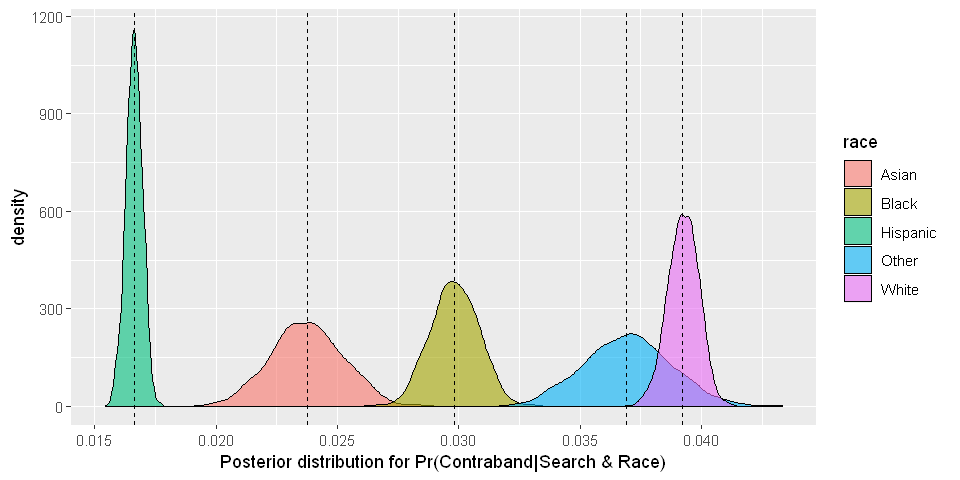

In [24]:
wht_n_hits <- sum(data[data$driver_race == 'White' &
                             data$search_conducted == 1, ]$contraband_found)
wht_hit_rate <- wht_n_hits / wht_n_search

his_n_hits <- sum(data[data$driver_race == 'Hispanic' &
                             data$search_conducted == 1, ]$contraband_found)
his_hit_rate <- his_n_hits / his_n_search 

blk_n_hits <- sum(data[data$driver_race == 'Black' &
                             data$search_conducted == 1, ]$contraband_found)
blk_hit_rate <- blk_n_hits / blk_n_search

asn_n_hits <- sum(data[data$driver_race == 'Asian' &
                             data$search_conducted == 1, ]$contraband_found)
asn_hit_rate <- asn_n_hits / asn_n_search

otr_n_hits <- sum(data[data$driver_race == 'Other' & 
                             data$search_conducted == 1, ]$contraband_found)
otr_hit_rate <- otr_n_hits / otr_n_search 

## MAKE AND PLOT PRIOR DISTRIBUTION OF SEARCH RATES FOR EACH RACE
## REPEAT THE SAME PROCESS IN ANOTHER BLOCK FOR THE HIT RATES

white_est <- data.frame(length = rbeta(n = 2000, 
                                       shape1 = wht_n_hits + 1/2, 
                                       shape2 = wht_n_search - wht_n_hits + 1/2))
black_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = blk_n_hits + 1/2,
                                          shape2 = blk_n_search - blk_n_hits + 1/2))

hispanic_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = his_n_hits + 1/2,
                                          shape2 = his_n_search - his_n_hits + 1/2))

asian_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = asn_n_hits + 1/2,
                                          shape2 = asn_n_search - asn_n_hits + 1/2))

other_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = otr_n_hits + 1/2,
                                          shape2 = otr_n_search - otr_n_hits + 1/2))

white_est$race <- 'White'
black_est$race <- 'Black'
asian_est$race <- 'Asian'
hispanic_est$race <- 'Hispanic'
other_est$race <- 'Other'

sim_data <- rbind(white_est, 
                  black_est, 
                  asian_est, 
                  hispanic_est, 
                  other_est)

ggplot(sim_data, aes(length, fill = race)) + 
    geom_density(alpha = 0.60) +
    geom_vline(xintercept = wht_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = blk_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = asn_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = otr_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = his_hit_rate, linetype = 'dashed') +
    xlab('Posterior distribution for Pr(Contraband|Search & Race)')

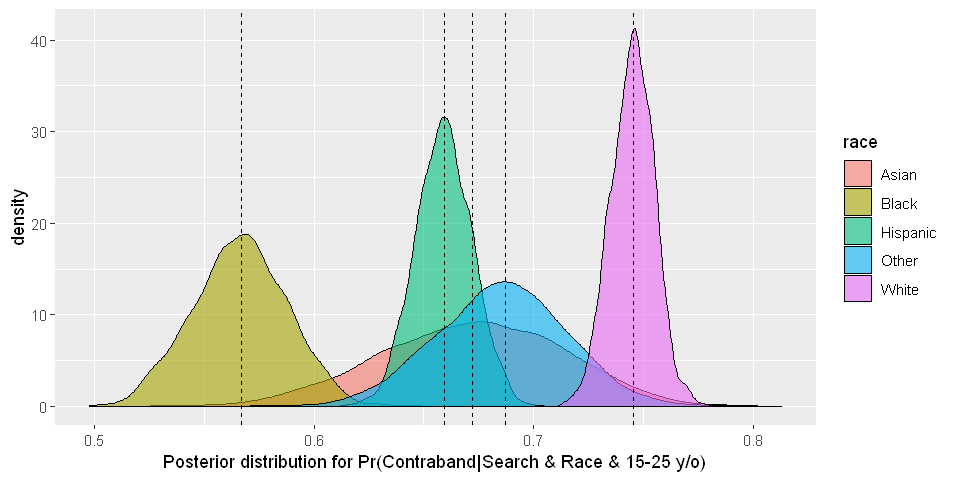

In [25]:
wht_n_search <- sum(data[data$driver_race == 'White' &
                               data$driver_age_raw == '2', ]$search_conducted)

wht_n_hits <- sum(data[data$driver_race == 'White' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2', ]$contraband_found)
wht_hit_rate <- wht_n_hits / wht_n_search

his_n_search <- sum(data[data$driver_race == 'Hispanic' &
                               data$driver_age_raw == '2', ]$search_conducted)

his_n_hits <- sum(data[data$driver_race == 'Hispanic' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2', ]$contraband_found)
his_hit_rate <- his_n_hits / his_n_search 

blk_n_search <- sum(data[data$driver_race == 'Black' &
                               data$driver_age_raw == '2', ]$search_conducted)

blk_n_hits <- sum(data[data$driver_race == 'Black' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2', ]$contraband_found)
blk_hit_rate <- blk_n_hits / blk_n_search

asn_n_search <- sum(data[data$driver_race == 'Asian' &
                               data$driver_age_raw == '2', ]$search_conducted)

asn_n_hits <- sum(data[data$driver_race == 'Asian' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2', ]$contraband_found)
asn_hit_rate <- asn_n_hits / asn_n_search

otr_n_search <- sum(data[data$driver_race == 'Other' & 
                               data$driver_age_raw == '2', ]$search_conducted)

otr_n_hits <- sum(data[data$driver_race == 'Other' & 
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2', ]$contraband_found)
otr_hit_rate <- otr_n_hits / otr_n_search 

## MAKE AND PLOT PRIOR DISTRIBUTION OF SEARCH RATES FOR EACH RACE
## REPEAT THE SAME PROCESS IN ANOTHER BLOCK FOR THE HIT RATES

white_est <- data.frame(length = rbeta(n = 2000, 
                                       shape1 = wht_n_hits + 1/2, 
                                       shape2 = wht_n_search - wht_n_hits + 1/2))
black_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = blk_n_hits + 1/2,
                                          shape2 = blk_n_search - blk_n_hits + 1/2))

hispanic_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = his_n_hits + 1/2,
                                          shape2 = his_n_search - his_n_hits + 1/2))

asian_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = asn_n_hits + 1/2,
                                          shape2 = asn_n_search - asn_n_hits + 1/2))

other_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = otr_n_hits + 1/2,
                                          shape2 = otr_n_search - otr_n_hits + 1/2))

white_est$race <- 'White'
black_est$race <- 'Black'
asian_est$race <- 'Asian'
hispanic_est$race <- 'Hispanic'
other_est$race <- 'Other'

sim_data <- rbind(white_est, 
                  black_est, 
                  asian_est, 
                  hispanic_est, 
                  other_est)

ggplot(sim_data, aes(length, fill = race)) + 
    geom_density(alpha = 0.60) +
    geom_vline(xintercept = wht_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = blk_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = asn_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = otr_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = his_hit_rate, linetype = 'dashed') +
    xlab('Posterior distribution for Pr(Contraband|Search & Race & 15-25 y/o)')

It is possible that the inclusion of individuals under suspicion of DUI may be adding a bias term to our estimates of the search and contraband rate. Suppose that a Police Officer pulls someone over for a DUI, and they actually are impaired. In this case, the officer essentially has probable cause on a silver platter, and will likely go forward with a search after arresting the driver. So, let's have a look at only those who have "Moving Violations". I.e., they were speeding, ran a light, or otherwise had an infraction that is fairly common on the road. We will stick to drivers who are 15-25, as they seem to carry contraband at higher rates.

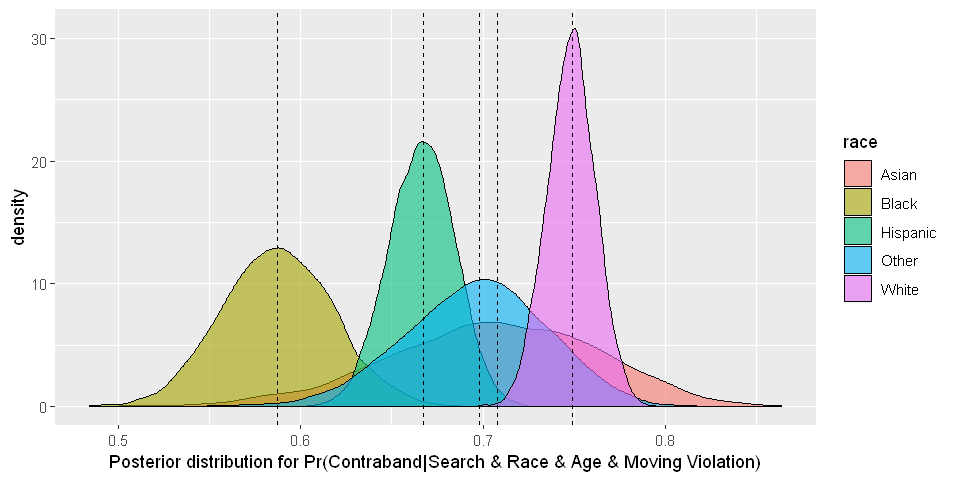

In [26]:
wht_n_search <- sum(data[data$driver_race == 'White' &
                               data$driver_age_raw == '2' &
                               violation == 2, ]$search_conducted)

wht_n_hits <- sum(data[data$driver_race == 'White' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2' &
                             violation == 2, ]$contraband_found)
wht_hit_rate <- wht_n_hits / wht_n_search

his_n_search <- sum(data[data$driver_race == 'Hispanic' &
                               data$driver_age_raw == '2' &
                               violation == 2, ]$search_conducted)

his_n_hits <- sum(data[data$driver_race == 'Hispanic' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2' &
                             violation ==2, ]$contraband_found)
his_hit_rate <- his_n_hits / his_n_search 

blk_n_search <- sum(data[data$driver_race == 'Black' &
                               data$driver_age_raw == '2' &
                               violation == 2, ]$search_conducted)

blk_n_hits <- sum(data[data$driver_race == 'Black' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2' &
                             violation == 2, ]$contraband_found)
blk_hit_rate <- blk_n_hits / blk_n_search

asn_n_search <- sum(data[data$driver_race == 'Asian' &
                               data$driver_age_raw == '2' &
                               violation == 2, ]$search_conducted)

asn_n_hits <- sum(data[data$driver_race == 'Asian' &
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2' &
                             violation == 2, ]$contraband_found)
asn_hit_rate <- asn_n_hits / asn_n_search

otr_n_search <- sum(data[data$driver_race == 'Other' & 
                               data$driver_age_raw == '2' &
                               violation == 2, ]$search_conducted)

otr_n_hits <- sum(data[data$driver_race == 'Other' & 
                             data$search_conducted == 1 &
                             data$driver_age_raw == '2' &
                             violation ==2, ]$contraband_found)
otr_hit_rate <- otr_n_hits / otr_n_search 

## MAKE AND PLOT PRIOR DISTRIBUTION OF SEARCH RATES FOR EACH RACE
## REPEAT THE SAME PROCESS IN ANOTHER BLOCK FOR THE HIT RATES

white_est <- data.frame(length = rbeta(n = 5000, 
                                       shape1 = wht_n_hits + 1/2, 
                                       shape2 = wht_n_search - wht_n_hits + 1/2))
black_est <- data.frame(length = rbeta(n = 5000, 
                                          shape1 = blk_n_hits + 1/2,
                                          shape2 = blk_n_search - blk_n_hits + 1/2))

hispanic_est <- data.frame(length = rbeta(n = 5000, 
                                          shape1 = his_n_hits + 1/2,
                                          shape2 = his_n_search - his_n_hits + 1/2))

asian_est <- data.frame(length = rbeta(n = 5000, 
                                          shape1 = asn_n_hits + 1/2,
                                          shape2 = asn_n_search - asn_n_hits + 1/2))

other_est <- data.frame(length = rbeta(n = 5000, 
                                          shape1 = otr_n_hits + 1/2,
                                          shape2 = otr_n_search - otr_n_hits + 1/2))

white_est$race <- 'White'
black_est$race <- 'Black'
asian_est$race <- 'Asian'
hispanic_est$race <- 'Hispanic'
other_est$race <- 'Other'

sim_data <- rbind(white_est, 
                  black_est, 
                  asian_est, 
                  hispanic_est, 
                  other_est)

ggplot(sim_data, aes(length, fill = race)) + 
    geom_density(alpha = 0.60) +
    geom_vline(xintercept = wht_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = blk_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = asn_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = otr_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = his_hit_rate, linetype = 'dashed') +
    xlab('Posterior distribution for Pr(Contraband|Search & Race & Age & Moving Violation)')

What if we only look at those individuals who were searched because of "probable cause"? This is an interesting one, because "probable cause" is essentially a judgement made by the officer. If the officer sees a certain amount of evidence of wrong doing, they then may decide that they have "probable cause". The long running joke here is the officer stating "I smell weed in your car", then conducting a search, when maurijuana may or may not actually be present.

More or less, these are searches that were made up to the officer's personal discretion, as opposed to a search conducted in the face of a confirmed DUI, which happens essentially automatically. 

In [27]:
unique(data$search_type)
dim(data[data$search_type == 'Probable Cause',])

[1] NA               "Probable Cause" "Consent"

[1] 10087    12

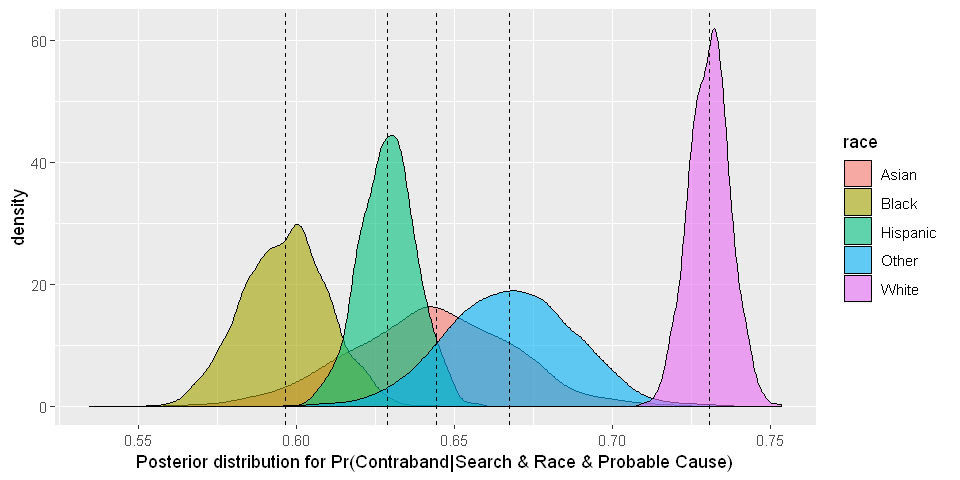

In [28]:
wht_n_search <- sum(data[data$driver_race == 'White' &
                         data$search_type == 'Probable Cause', ]$search_conducted)

wht_n_hits <- sum(data[data$driver_race == 'White' &
                             data$search_conducted == 1 &
                             data$search_type == 'Probable Cause', ]$contraband_found)
wht_hit_rate <- wht_n_hits / wht_n_search

his_n_search <- sum(data[data$driver_race == 'Hispanic' &
                         data$search_type == 'Probable Cause', ]$search_conducted)

his_n_hits <- sum(data[data$driver_race == 'Hispanic' &
                       data$search_conducted == 1 &
                       data$search_type == 'Probable Cause', ]$contraband_found)
his_hit_rate <- his_n_hits / his_n_search 

blk_n_search <- sum(data[data$driver_race == 'Black' &
                         data$search_type == 'Probable Cause', ]$search_conducted)

blk_n_hits <- sum(data[data$driver_race == 'Black' &
                       data$search_conducted == 1 &
                       data$search_type == 'Probable Cause', ]$contraband_found)
blk_hit_rate <- blk_n_hits / blk_n_search

asn_n_search <- sum(data[data$driver_race == 'Asian' &
                         data$search_type == 'Probable Cause', ]$search_conducted)

asn_n_hits <- sum(data[data$driver_race == 'Asian' &
                       data$search_conducted == 1 &
                       data$search_type == 'Probable Cause', ]$contraband_found)
asn_hit_rate <- asn_n_hits / asn_n_search

otr_n_search <- sum(data[data$driver_race == 'Other' & 
                         data$search_type == 'Probable Cause', ]$search_conducted)

otr_n_hits <- sum(data[data$driver_race == 'Other' & 
                       data$search_conducted == 1 &
                       data$search_type == 'Probable Cause', ]$contraband_found)
otr_hit_rate <- otr_n_hits / otr_n_search 

## MAKE AND PLOT PRIOR DISTRIBUTION OF SEARCH RATES FOR EACH RACE
## REPEAT THE SAME PROCESS IN ANOTHER BLOCK FOR THE HIT RATES

white_est <- data.frame(length = rbeta(n = 2000, 
                                       shape1 = wht_n_hits + 1/2, 
                                       shape2 = wht_n_search - wht_n_hits + 1/2))
black_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = blk_n_hits + 1/2,
                                          shape2 = blk_n_search - blk_n_hits + 1/2))

hispanic_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = his_n_hits + 1/2,
                                          shape2 = his_n_search - his_n_hits + 1/2))

asian_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = asn_n_hits + 1/2,
                                          shape2 = asn_n_search - asn_n_hits + 1/2))

other_est <- data.frame(length = rbeta(n = 2000, 
                                          shape1 = otr_n_hits + 1/2,
                                          shape2 = otr_n_search - otr_n_hits + 1/2))

white_est$race <- 'White'
black_est$race <- 'Black'
asian_est$race <- 'Asian'
hispanic_est$race <- 'Hispanic'
other_est$race <- 'Other'

sim_data <- rbind(white_est, 
                  black_est, 
                  asian_est, 
                  hispanic_est, 
                  other_est)

ggplot(sim_data, aes(length, fill = race)) + 
    geom_density(alpha = 0.60) +
    geom_vline(xintercept = wht_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = blk_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = asn_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = otr_hit_rate, linetype = 'dashed') +
    geom_vline(xintercept = his_hit_rate, linetype = 'dashed') +
    xlab('Posterior distribution for Pr(Contraband|Search & Race & Probable Cause)')

####TODO: impute missing values, rerun visualizations. Possibly use propensity scores?